# Robust regression with Julia and JuMP

Example problem: Identifying the sea clutter in Weather Radar data.

→ a **robust regression** problem.

Inspired by:

* Radar data: P.-J. Trombe *et al.*, “Weather radars – the new eyes for offshore wind farms?,” *Wind Energy*, 2014.
* Regression methods: S. Boyd and L. Vandenberghe, Convex Optimization. Cambridge University Press, 2004. (Example 6.2)

see [radar_data_generation.ipynb](radar_data_generation.ipynb) for the generation of the dataset.

Modules for optimization

In [1]:
using JuMP
using Clp
using ECOS # for Second-order cone constraints http://www.juliaopt.org/JuMP.jl/0.18/refmodel.html#second-order-cone-constraints
using Ipopt # quadratic objective

Module for plotting

In [2]:
using PyPlot

## Load the dataset

In [3]:
data = readcsv("radar_data.csv");

In [4]:
n = size(data)[1]

300

In [5]:
x = data[:,1]
y = data[:,2];

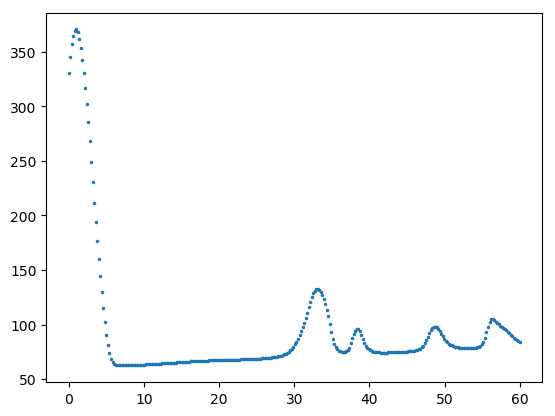

In [6]:
plot(x,y, ".", ms=3);

## Choice of penaly function

The parameters for the trend $(a,b)$ should minimize a criterion $J$ which penalizes the residuals $r_i = y_i - \hat{y} = y_i - a.x + b$:

$$ J(a,b) = \sum_i \phi(r_i)$$

where $\phi$ is the *penaly function*, to be chosen:

* $\phi(r) = r^2$: quadratic deviation → least squares regression
* $\phi(r) = \lvert r \rvert$: absolute value deviation
* $\phi(r) = h(r)$: [Huber loss](https://en.wikipedia.org/wiki/Huber_loss)

In [11]:
function huber(r)
    if abs(r) <= 1
        return r^2
    else
        return 2*abs(r) - 1
    end
end

huber (generic function with 1 method)

In [12]:
huber.([0,0.5,1,2])

4-element Array{Float64,1}:
 0.0 
 0.25
 1.0 
 3.0 

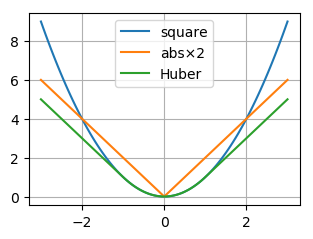

In [29]:
r_range = linspace(-3,3, 101)

figure(figsize=(3.5,2.5))
plot(r_range, r_range.^2, label="square")
plot(r_range, 2*abs.(r_range), label="abs×2")
plot(r_range, huber.(r_range), label="Huber")
legend()
grid()
savefig("loss_func.png", dpi=200, bbox_inches="tight")

## Least square regression

model:

$$\hat{y} = a.x+b$$

$$\theta = (b,a)^T$$

$$ \min_\theta \lVert X\theta - y \lVert_2 $$

### Using the backslash `\` operator like in Matlab

NB: the fact that it works with rectangular matrices is a bit hidden in the doc:

In [32]:
?\

search: \ .\



```
\(x, y)
```

Left division operator: multiplication of `y` by the inverse of `x` on the left. Gives floating-point results for integer arguments.

```jldoctest
julia> 3 \ 6
2.0

julia> inv(3) * 6
2.0

julia> A = [1 2; 3 4]; x = [5, 6];

julia> A \ x
2-element Array{Float64,1}:
 -4.0
  4.5

julia> inv(A) * x
2-element Array{Float64,1}:
 -4.0
  4.5
```

```
\(A, B)
```

Matrix division using a polyalgorithm. For input matrices `A` and `B`, the result `X` is such that `A*X == B` when `A` is square. The solver that is used depends upon the structure of `A`.  If `A` is upper or lower triangular (or diagonal), no factorization of `A` is required and the system is solved with either forward or backward substitution. For non-triangular square matrices, an LU factorization is used.

For rectangular `A` the result is the minimum-norm least squares solution computed by a pivoted QR factorization of `A` and a rank estimate of `A` based on the R factor.

When `A` is sparse, a similar polyalgorithm is used. For indefinite matrices, the `LDLt` factorization does not use pivoting during the numerical factorization and therefore the procedure can fail even for invertible matrices.

# Example

```jldoctest
julia> A = [1 0; 1 -2]; B = [32; -4];

julia> X = A \ B
2-element Array{Float64,1}:
 32.0
 18.0

julia> A * X == B
true
```


In [30]:
X = hcat(ones(x), x);

In [31]:
b_ls, a_ls = X \ y
a_ls, b_ls

(-1.094307150714308, 127.525735280701)

### Now using JuMP

helper function to suppress the solver blablabla

In [35]:
function solve_silent(m)
    TT = STDOUT # save original STDOUT stream
    redirect_stdout()
    status = solve(m)
    redirect_stdout(TT) # restore STDOUT
    status
end

solve_silent (generic function with 1 method)

Common part for any regression problem

In [45]:
m = Model(solver = ECOSSolver())

@variable(m, a )
@variable(m, b )

b

residuals: `res` (“residuals”) is an Array of 300 elements of type `JuMP.GenericAffExpr{Float64,JuMP.Variable}`, i.e. a semi-symbolic affine expression.

In [46]:
res = a*x .- y +b

300-element Array{JuMP.GenericAffExpr{Float64,JuMP.Variable},1}:
 b - 330.0000004216058                        
 0.20066889632107024 a + b - 345.0355187060472
 0.4013377926421405 a + b - 356.5855778903129 
 0.6020066889632107 a + b - 364.6501778504438 
 0.802675585284281 a + b - 369.2293185525956  
 1.0033444816053512 a + b - 370.32299998680895
 1.2040133779264215 a + b - 367.9312221514166 
 1.4046822742474916 a + b - 362.0539850507466 
 1.605351170568562 a + b - 352.9823694277756  
 1.8060200668896322 a + b - 342.29916802426004
 2.0066889632107023 a + b - 330.2426578892699 
 2.2073578595317724 a + b - 316.8128392535288 
 2.408026755852843 a + b - 302.00971281527757 
 ⋮                                            
 57.79264214046823 a + b - 97.06107979605143  
 57.9933110367893 a + b - 95.90959196763387   
 58.19397993311037 a + b - 94.67049759008214  
 58.39464882943144 a + b - 93.36561430234113  
 58.59531772575251 a + b - 92.01975148880365  
 58.79598662207358 a + b - 90.660262577096

### Reformulation as SOCP

the Quadratic Program:

$$\min \sum_i r_i^2$$

is reformulated as a [Second-Order Cone Program](https://en.wikipedia.org/wiki/Second-order_cone_programming) (SOCP):

$$\min j, \quad \text{such that} \; \lVert r \rVert_2 \leq j$$

In [47]:
@variable(m, j )
@constraint(m, norm(res) <= j)

@objective(m, Min, j)

j

In [48]:
status = solve_silent(m)

:Optimal

In [49]:
getvalue(a), getvalue(b)

(-1.094307126964816, 127.52573439383087)

NB: exactly the same result obtained with `\`

In [50]:
a_ls, b_ls

(-1.094307150714308, 127.525735280701)

## Least absolute value

$$\min \sum_i \lvert r_i \rvert $$

reformulated as a [Linear Program](https://en.wikipedia.org/wiki/Linear_programming) (LP)

$$\min \sum_i t_i, \quad \text{such that} \; -t_i \leq r_i \leq t_i$$

In [51]:
using Clp

Common part

In [53]:
m = Model(solver = ClpSolver())

@variable(m, a )
@variable(m, b )
res = a*x .- y +b;

Specific part

In [54]:
@variable(m, t[1:n] )
@constraint(m, res .<= t)
@constraint(m, res .>= -t)
@objective(m, Min, sum(t));

In [55]:
status = solve(m)

:Optimal

In [56]:
a_lav, b_lav = getvalue(a), getvalue(b)

(0.43761021724890264, 59.09093873002771)

## Huber

$$ \min_\theta  \sum_k h( y_k - ax_k - b) $$

with Huber penalty function $h$

$$h(r) = \begin{cases}
    r^2&                  \lvert r \rvert \leq 1 \\
    2\lvert r \rvert - 1& \lvert r \rvert    > 1
\end{cases}
$$

Boyd Example 6.2

http://cvxopt.org/examples/book/huber.html

#### QP variant

In [58]:
m = Model(solver = IpoptSolver())

@variable(m, a)
@variable(m, b)
@variable(m, 0 <= u[1:n] <= 1)
@variable(m, v[1:n] >= 0)

res = (a*x .- y +b)/10 # scaling of residuals, to set the transition between quadratic and lin penalty

@constraint(m, res .<=  u .+ v)
@constraint(m, res .>= -u .- v)
@objective(m, Min, 1/2*u'*u + sum(v));

In [59]:
tic()
status = solve_silent(m)
toc()
status

elapsed time: 0.965436248 seconds


:Optimal

In [60]:
a_hub, b_hub = getvalue(a), getvalue(b)

(0.39673183462804185, 63.982469342717984)

#### SOCP variant

In [62]:
m = Model(solver = ECOSSolver(log=1))

@variable(m, a)
@variable(m, b)
@variable(m, u_norm)
@variable(m, 0 <= u[1:n] <= 1)
@variable(m, v[1:n] >= 0)

res = (a*x .- y +b)/10 # scaling of residuals, to set the transition between quadratic and lin penalty

@constraint(m, res .<=  u .+ v)
@constraint(m, res .>= -u .- v)
@constraint(m, norm(u) <= u_norm) 
@objective(m, Min, 1/2*u_norm + sum(v));

In [63]:
tic()
status = solve(m)
toc()

elapsed time: 0.153289724 seconds


0.153289724

## Plot: comparison of the results

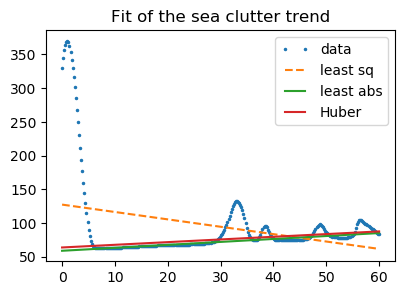

In [70]:
figure(figsize=(4.5,3))

title("Fit of the sea clutter trend")
plot(x,y, ".", ms=3, label="data")

plot(x,a_ls*x+b_ls, "--", label="least sq")
plot(x,a_lav*x+b_lav, "-", label="least abs")
plot(x,a_hub*x+b_hub, "-", label="Huber")

legend(numpoints=2)
savefig("radar_fit_cmp.png",dpi=200)

Ccl: least squares is bad, as expected. LAD is ok, and Huber also (depends on the scaling).

NB: in original article (Trombe 2014), they use another technique, [Least trimmed squares](https://en.wikipedia.org/wiki/Least_trimmed_squares). I don't know if this can be modeled with JuMP. I suspect it's not so easy (not convex?).